# Directed Graph - Representations

---

## Adjacency List

* Represent graph as a dictionary or list mapping each node to a list of its neighbors.
* Traversing neighbors is fast because only the connected nodes are stored.
* Good for *sparse* graphs: contrast with adjacency matrices which store $n^2$ entries, which wastes memory on absent edges.

In [1]:
from abc import ABC, abstractmethod
from collections import defaultdict
from dataclasses import dataclass
from typing import Dict, Generic, List, Tuple, TypeVar

import matplotlib.pyplot as plt
import networkx as nx

In [2]:
T = TypeVar("T")


@dataclass
class GraphNode(Generic[T]):
    value: T

    def __hash__(self) -> int:
        return hash(self.value)

    def __eq__(self, other: object) -> bool:
        if not isinstance(other, GraphNode):
            return NotImplemented
        return self.value == other.value

    def __lt__(self, other: "GraphNode[T]") -> bool:
        """Required for heapq comparison"""
        return self.value < other.value


class Graph(Generic[T], ABC):
    @abstractmethod
    def to_networkx(self) -> nx.Graph:
        pass

    def visualise(self) -> None:
        g = self.to_networkx()
        pos = nx.spring_layout(g, k=2.5, iterations=50)
        plt.figure(figsize=(8, 6))
        plt.title("Graph Visualization", fontsize=14)

        edge_weights = nx.get_edge_attributes(g, "weight")

        nx.draw_networkx_nodes(
            g,
            pos,
            node_color="lightblue",
            node_size=400,
        )
        nx.draw_networkx_edges(
            g,
            pos,
            width=2.5,
            arrows=True,
            arrowsize=30,
            arrowstyle="->",
            edge_color="gray",
        )
        nx.draw_networkx_labels(g, pos, font_size=12)
        nx.draw_networkx_edge_labels(g, pos, edge_weights, font_size=9)

        plt.axis("off")
        plt.tight_layout()
        plt.show()

In [3]:
class AdjacencyListDirectedGraph(Graph[T]):
    def __init__(
        self, weighted_adj: Dict[GraphNode[T], Dict[GraphNode[T], float]]
    ) -> None:
        self.adjacency_list: Dict[GraphNode[T], List[GraphNode[T]]] = defaultdict(list)
        self.edge_weights: Dict[Tuple[GraphNode[T], GraphNode[T]], float] = {}

        # Build adjacency list and weights
        for source, targets in weighted_adj.items():
            for target, weight in targets.items():
                self.adjacency_list[source].append(target)
                self.edge_weights[(source, target)] = weight

    def get_weight(self, source: GraphNode[T], target: GraphNode[T]) -> float:
        return self.edge_weights.get((source, target), 1.0)

    def to_networkx(self) -> nx.DiGraph:
        g = nx.DiGraph()

        # Collect all nodes
        all_nodes = set(self.adjacency_list.keys())
        for targets in self.adjacency_list.values():
            all_nodes.update(targets)

        for node in all_nodes:
            g.add_node(node.value)

        # Add weighted edges
        for source, targets in self.adjacency_list.items():
            for target in targets:
                g.add_edge(
                    source.value, target.value, weight=self.get_weight(source, target)
                )
        return g

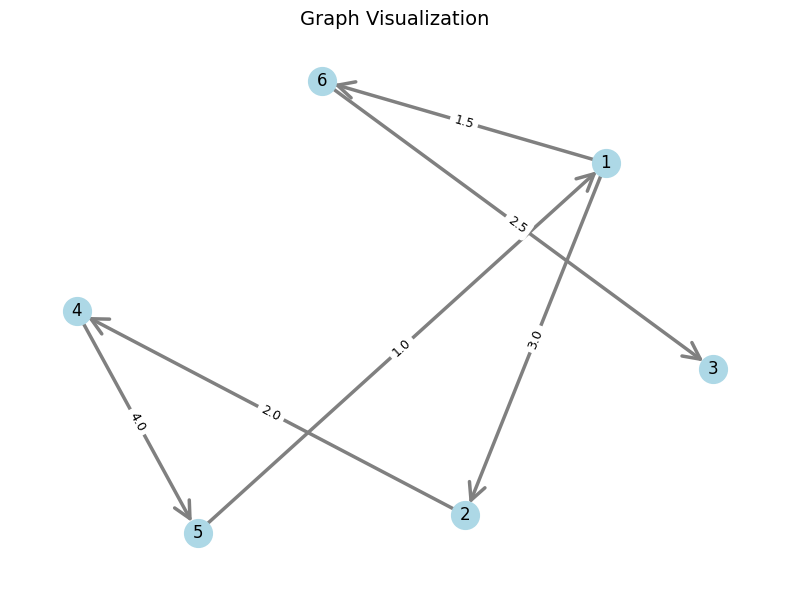

In [4]:
if __name__ == "__main__":
    adj_list_graph = AdjacencyListDirectedGraph(
        {
            GraphNode(1): {GraphNode(2): 3.0, GraphNode(6): 1.5},
            GraphNode(2): {GraphNode(4): 2.0},
            GraphNode(3): {},
            GraphNode(4): {GraphNode(5): 4.0},
            GraphNode(5): {GraphNode(1): 1.0},
            GraphNode(6): {GraphNode(3): 2.5},
        }
    )
    adj_list_graph.visualise()

## Adjacency Matrix

A 2D array where $M[i][j]$ indicates presence (and sometimes weight) of edge from $i$ to $j$.

* Easy to check if edge exists but expensive in space for large sparse graphs.
* Traversing neighbours may not be fast as it requires checking the entire row.

In [5]:
class AdjacencyMatrixDirectedGraph(Graph[T]):
    def __init__(self, nodes: List[GraphNode[T]], matrix: List[List[float]]) -> None:
        self.nodes = nodes
        self.adj_matrix = matrix

    def to_networkx(self) -> nx.DiGraph:
        g = nx.DiGraph()
        n = len(self.nodes)

        # Add all nodes first
        for node in self.nodes:
            g.add_node(node.value)

        # Add weighted edges from matrix
        for i in range(n):
            for j in range(n):
                if self.adj_matrix[i][j] != 0.0:
                    g.add_edge(
                        self.nodes[i].value,
                        self.nodes[j].value,
                        weight=self.adj_matrix[i][j],
                    )

        return g

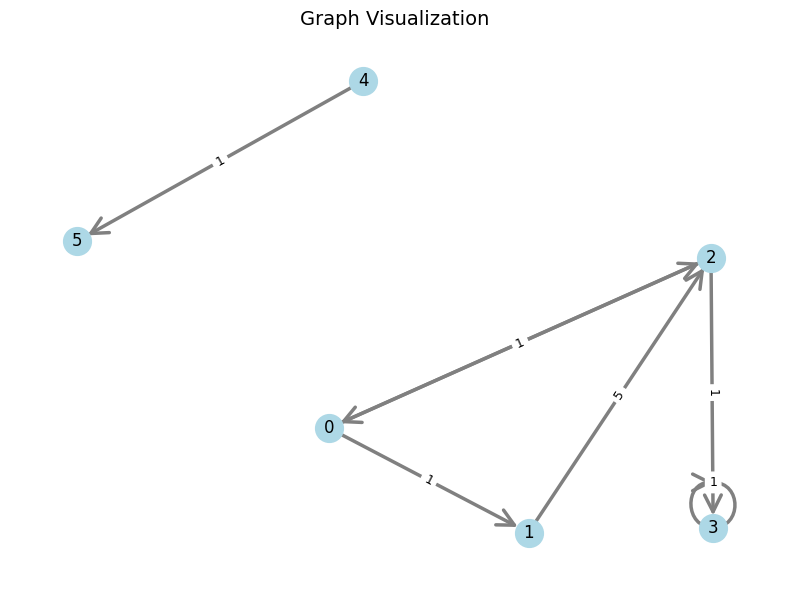

In [6]:
if __name__ == "__main__":
    nodes = [GraphNode(i) for i in range(6)]
    matrix = [
        [0, 1, 4, 0, 0, 0],
        [0, 0, 5, 0, 0, 0],
        [1, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0],
    ]

    adj_matrix_graph = AdjacencyMatrixDirectedGraph(nodes, matrix)
    adj_matrix_graph.visualise()